In [2]:
import os                   # to interact with the operating system
import glob

import numpy as np
import pandas as pd
import xarray as xr

import pop_tools
import gsw                  # compute potential density

import matplotlib as mpl
import matplotlib.pyplot as plt
import cartopy
import cmocean.cm as cmo
import matplotlib.ticker as ticker

from matplotlib import animation, gridspec

ccrs = cartopy.crs

In [3]:
# setting up of regional mask
grid_name = 'POP_gx1v7'
region_defs = {
    'SubpolarAtlantic':[
        {'match': {'REGION_MASK': [6]}, 'bounds': {'TLAT': [15.0, 66.0], 'TLONG': [260.0, 360.0]}}   
    ],
    'LabradorSea': [
        {'match': {'REGION_MASK': [8]}, 'bounds': {'TLAT': [45.0, 66.0]}}        
    ]}
maskBSF = pop_tools.region_mask_3d(grid_name, 
                                  region_defs=region_defs, 
                                  mask_name='Subpolar Gyre')
maskBSF = maskBSF.sum('region')  

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


# Plot all the nice ocean variables

initialisation complete
starting with TEMP
TEMP has been loaded
TEMP figure has been created
starting with SALT
SALT has been loaded
SALT figure has been created
starting with SIGMA_2
SIGMA_2 has been loaded
SIGMA_2 figure has been created
starting with HMXL
HMXL has been loaded
HMXL figure has been created
starting with SHF
SHF has been loaded
SHF figure has been created
starting with SSH
SSH has been loaded
SSH figure has been created


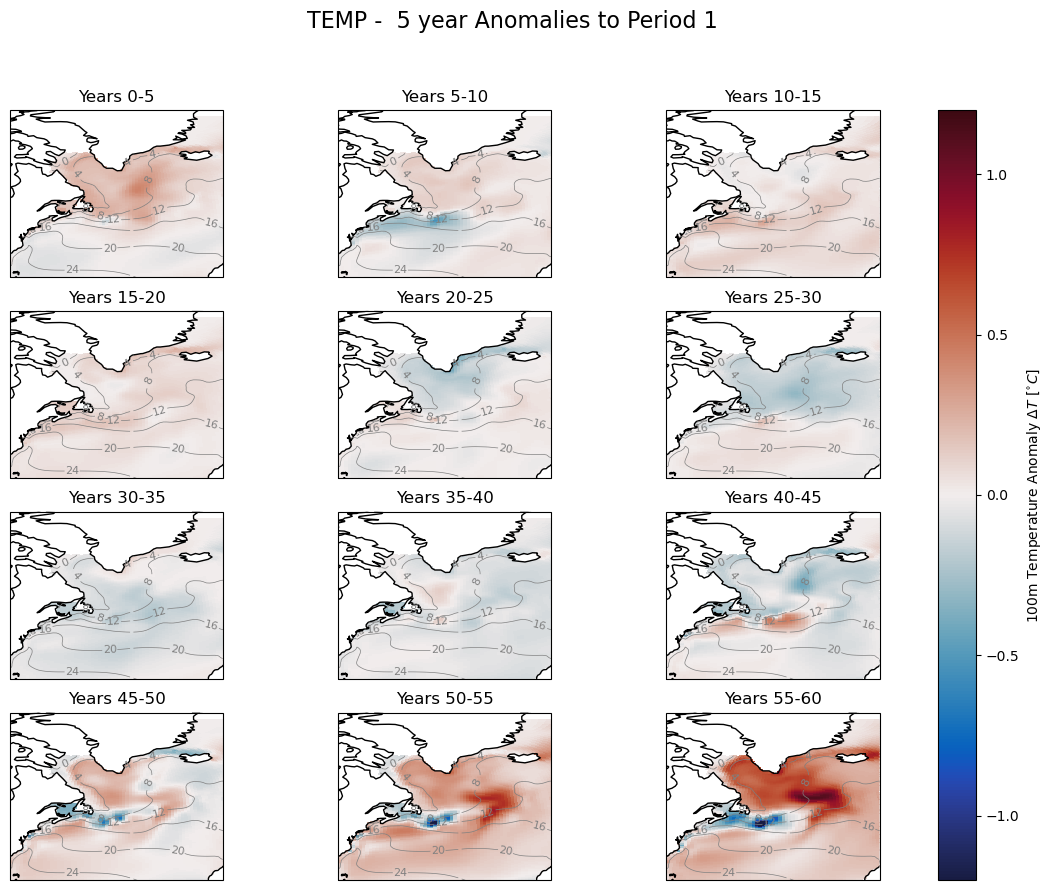

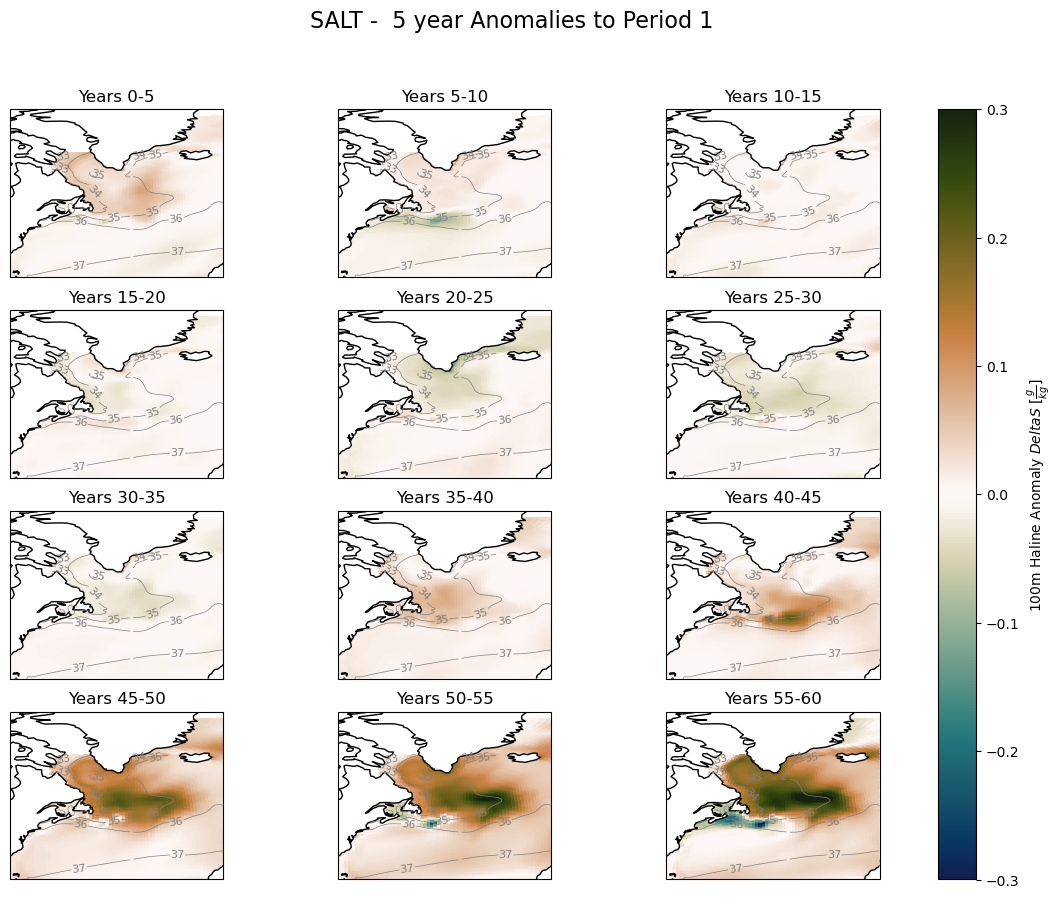

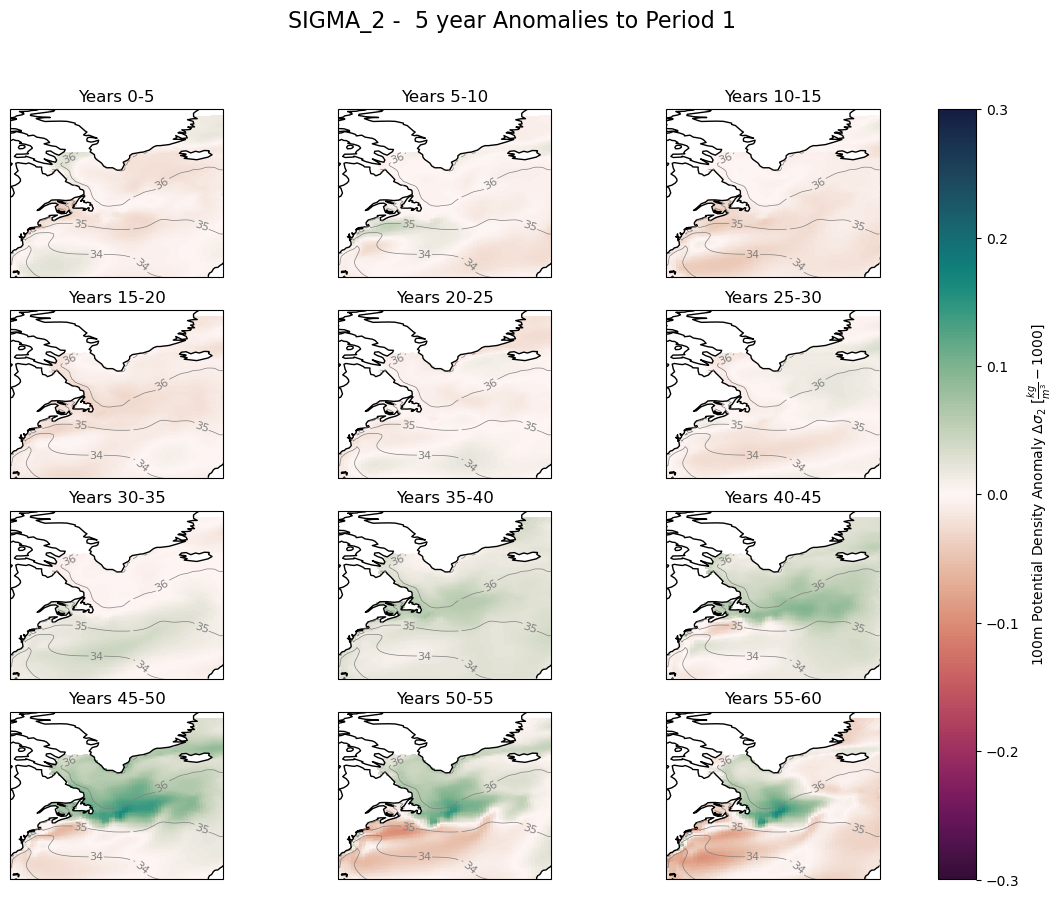

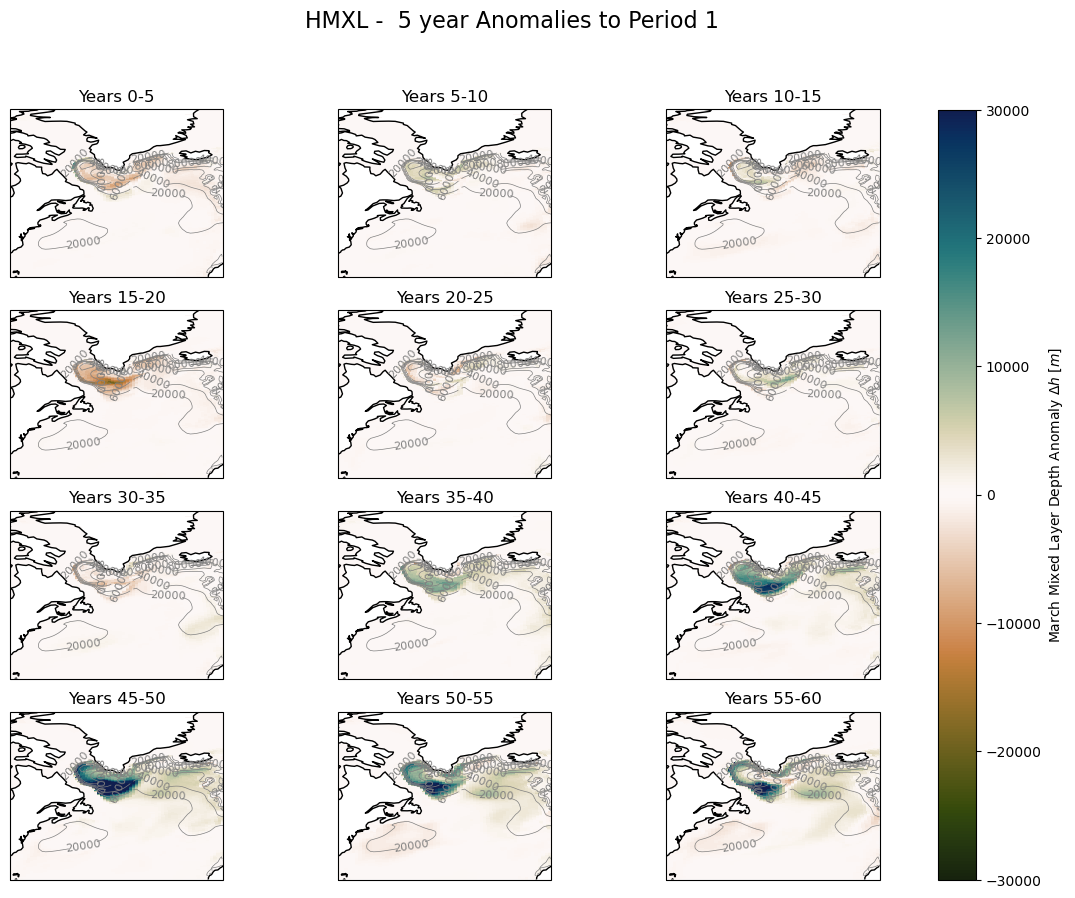

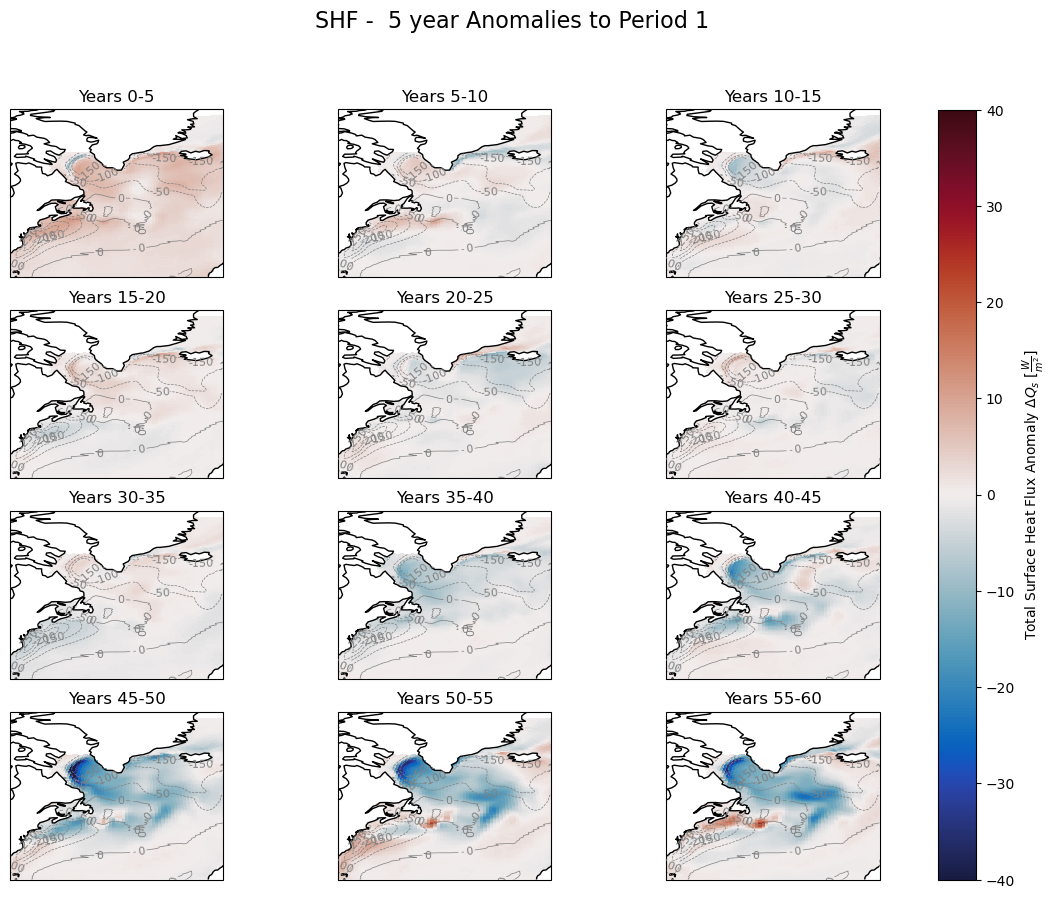

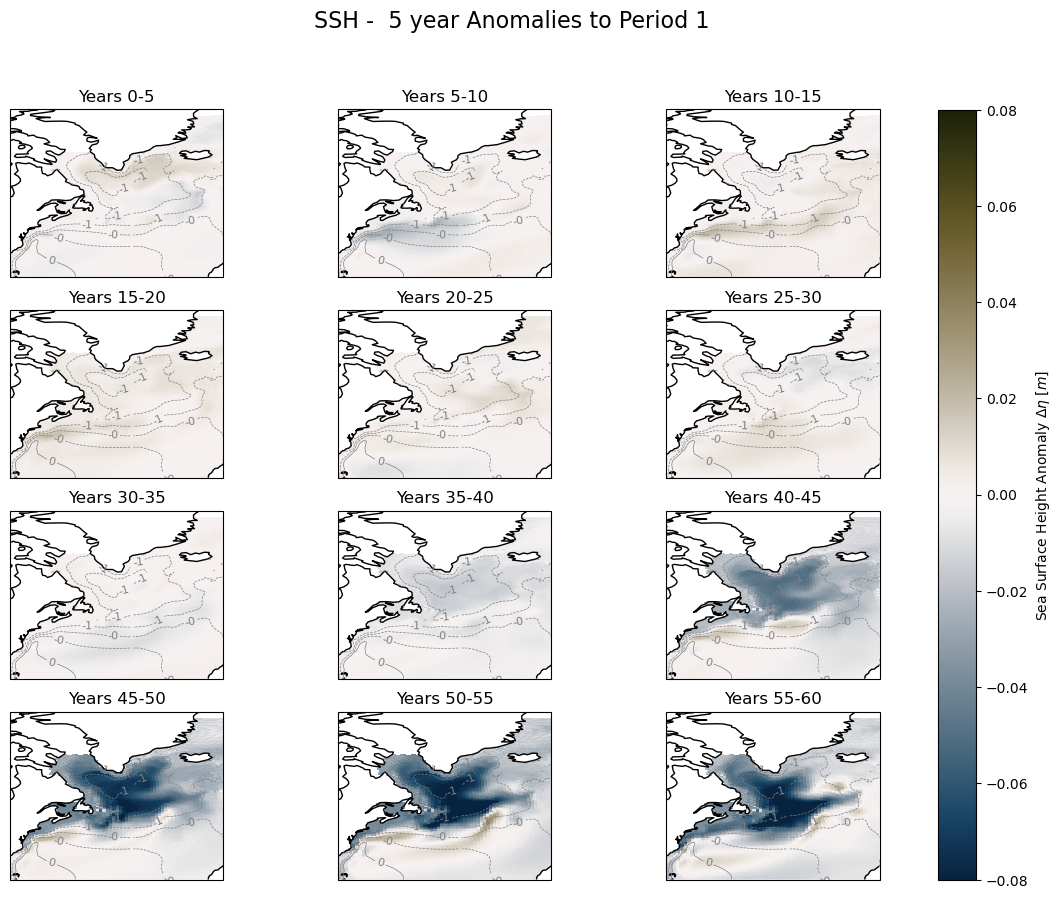

In [6]:
### INITIALISATION

files = sorted(glob.glob('/Data/gfi/share/ModData/CESM2_LENS2/ocean/monthly/comp/composite*.nc'))

variables = ['TEMP', 'SALT', 'SIGMA_2', 'HMXL', 'SHF', 'SSH']
#labels = [r'1000m Temperature Anomaly $\Delta T$ [$^{\circ} C$]', r'1000m Haline Anomaly $Delta S$ [$\frac{g}{kg}$]', r'1000m Potential Density Anomaly $\Delta\sigma_2$ [$\frac{kg}{m^3} -1000$]', r'March Mixed Layer Depth Anomaly $\Delta h$ [$m$]',r'Total Surface Heat Flux Anomaly $\Delta Q_s$ [$\frac{W}{m^2}$]', r'Sea Surface Height Anomaly $\Delta \eta$ [$m$]']
labels = [r'100m Temperature Anomaly $\Delta T$ [$^{\circ} C$]', r'100m Haline Anomaly $Delta S$ [$\frac{g}{kg}$]', r'100m Potential Density Anomaly $\Delta\sigma_2$ [$\frac{kg}{m^3} -1000$]', r'March Mixed Layer Depth Anomaly $\Delta h$ [$m$]',r'Total Surface Heat Flux Anomaly $\Delta Q_s$ [$\frac{W}{m^2}$]', r'Sea Surface Height Anomaly $\Delta \eta$ [$m$]']
cmaps = [cmo.balance, cmo.tarn_r, cmo.curl_r, cmo.tarn, cmo.balance, cmo.diff]
#vmins = [-0.6, -0.2, -0.1, -30000, -40, -0.08]
vmins = [-1.2, -0.3, -0.3, -30000, -40, -0.08]

print('initialisation complete')

### COMPUTATION

## create data

for v in range(len(variables)):
    
    var = variables[v]
    
    print('starting with '+var)
    
    ds_var_annual = xr.open_dataset('/Data/gfi/share/ModData/CESM2_LENS2/ocean/monthly/comp/' + var + 'composite.nc').roll(nlon=+100)
    
    replacement_value = 0
    # Replace non-finite values and masked values
    ds_var_annual['TLAT'] = xr.where(
        np.logical_or(np.isnan(ds_var_annual['TLAT']), np.isinf(ds_var_annual['TLAT']) | np.ma.getmask(ds_var_annual['TLAT'])),
        replacement_value,
        ds_var_annual['TLAT'])

    ds_var_annual['TLONG'] = xr.where(
        np.logical_or(np.isnan(ds_var_annual['TLONG']), np.isinf(ds_var_annual['TLONG']) | np.ma.getmask(ds_var_annual['TLONG'])),
        replacement_value,
        ds_var_annual['TLONG'])
    
    print(var+' has been loaded')

    vmin = vmins[v]
    vmax = -vmin
    
    if var == 'TEMP' or var == 'SALT' or var == 'SIGMA_2':
        #ds_var_annual = ds_var_annual.sel(z_t=slice(5.0000000e+02, 9.8470586e+04)).mean('z_t')
        ds_var_annual = ds_var_annual.sel(z_t=slice(5.0000000e+02, 1.050000e+04)).mean('z_t')
        ds = ds_var_annual - ds_var_annual.isel(time=slice(0,40)).mean('time')
    elif var == 'HMXL':
        ds_var_annual = ds_var_annual.roll(nlon=-100)
        ds = ds_var_annual - ds_var_annual.isel(time=slice(0,40)).mean('time')
    
    else:
        ds = ds_var_annual - ds_var_annual.isel(time=slice(0,40)).mean('time')
    
    
    fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(15, 10), subplot_kw={'projection': ccrs.PlateCarree()})

    # Loop through the subplots and plot the data
    for i, ax in enumerate(axes.flatten()):
        
        pc = ds[var].isel(time=range(i * 5, i * 5 + 5)).mean('time').plot.pcolormesh(ax=ax, 
                                                                                        transform=ccrs.PlateCarree(),
                                                                                        x='TLONG', 
                                                                                        y='TLAT',
                                                                                        cmap=cmaps[v],
                                                                                        vmin = vmin, vmax = vmax,
                                                                                        add_colorbar=False,) 
        ax.set_extent([-80,-10, 25, 80], crs=ccrs.PlateCarree())
        ax.set_title(f"Years {(i*5)}-{(i*5)+5}")
        ax.coastlines()
        
        cs = ax.contour(ds.TLONG, ds.TLAT, ds_var_annual[var].isel(time=slice(0, 40)).mean('time').where(maskBSF == 1), linewidths=0.5, colors='gray',transform=ccrs.PlateCarree())
        ax.clabel(cs, fmt='%1.0f', inline=True, fontsize=8)

    # Add a single colorbar for all plots outside the loop
    cbar = fig.colorbar(pc, ax=axes, orientation='vertical', label=labels[v])

    fig.suptitle(var+' -  5 year Anomalies to Period 1', fontsize=16)

    #plt.show()
    plt.savefig(os.path.expanduser('~/phase1_CONDA/results/')+var+'_5year_anomalies.png', bbox_inches='tight', dpi=300)    
    print(var+' figure has been created')


Get contours working

In [25]:
# get contours working

files = sorted(glob.glob('/Data/gfi/share/ModData/CESM2_LENS2/ocean/monthly/comp/composite*.nc'))

variables = ['TEMP', 'SALT', 'SIGMA_2', 'HMXL', 'SHF', 'SSH']
labels = [r'Temperature Anomaly $\Delta T$ [$^{\circ} C$]', r'Haline Anomaly $Delta S$ [$\frac{g}{kg}$]', r'Potential Density Anomaly $\Delta\sigma_2$ [$\frac{kg}{m^3} -1000$]', r'March Mixed Layer Depth Anomaly $\Delta h$ [$m$]',r'Total Surface Heat Flux Anomaly $\Delta Q_s$ [$\frac{W}{m^2}$]', r'Sea Surface Height Anomaly $\Delta \eta$ [$m$]']
cmaps = [cmo.balance, cmo.tarn_r, cmo.curl_r, cmo.tarn, cmo.balance, cmo.diff]
vmins = [-0.6, -0.2, -0.1, -30000, -40, -0.08]

print('initialisation complete')

### COMPUTATION

v=0
var = variables[v]

print('starting with '+var)

ds_var_annual = xr.open_dataset('/Data/gfi/share/ModData/CESM2_LENS2/ocean/monthly/comp/' + var + 'composite.nc').roll(nlon=+100)

replacement_value = 0
# Replace non-finite values and masked values
ds_var_annual['TLAT'] = xr.where(
    np.logical_or(np.isnan(ds_var_annual['TLAT']), np.isinf(ds_var_annual['TLAT']) | np.ma.getmask(ds_var_annual['TLAT'])),
    replacement_value,
    ds_var_annual['TLAT'])

ds_var_annual['TLONG'] = xr.where(
    np.logical_or(np.isnan(ds_var_annual['TLONG']), np.isinf(ds_var_annual['TLONG']) | np.ma.getmask(ds_var_annual['TLONG'])),
    replacement_value,
    ds_var_annual['TLONG'])

print(var+' has been loaded')

vmin = vmins[v]
vmax = -vmin



initialisation complete
starting with TEMP
TEMP has been loaded


Make same with PSL

initialisation complete
starting with PSL
PSL has been loaded
PSL figure has been created


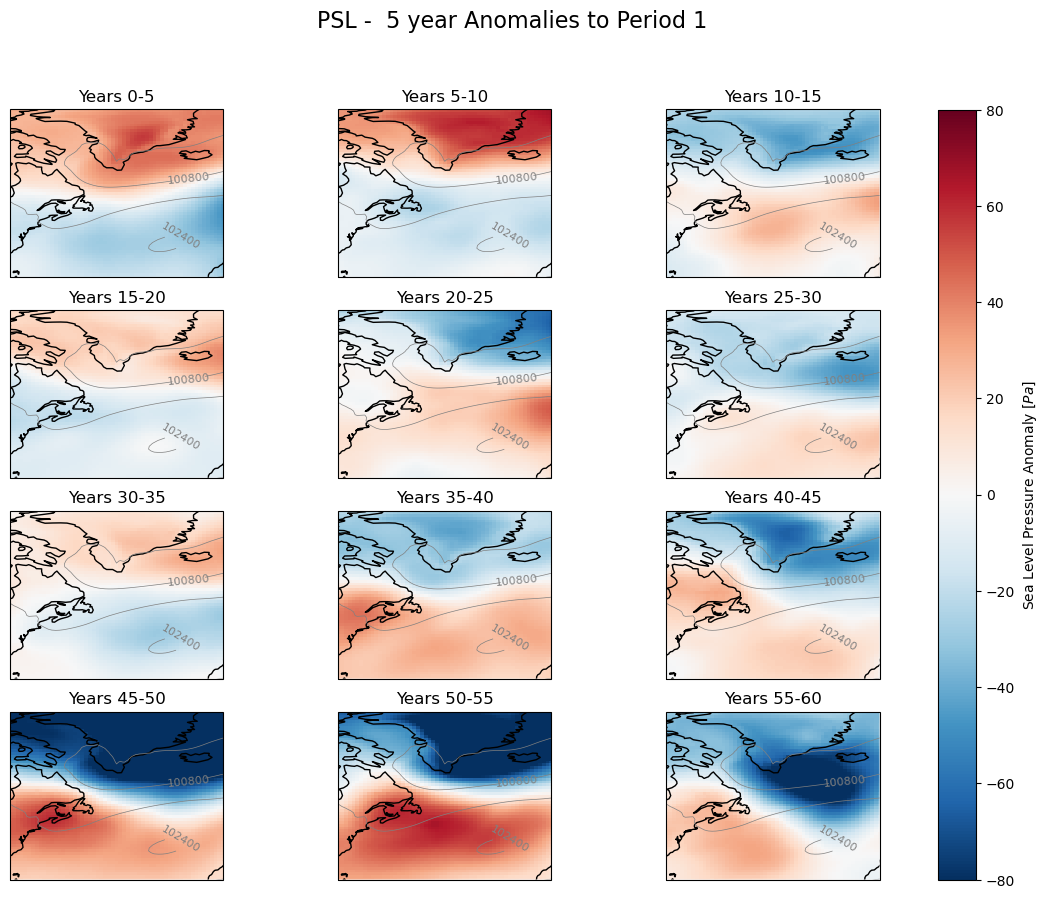

In [28]:
### INITIALISATION

files = sorted(glob.glob('/Data/gfi/share/ModData/CESM2_LENS2/ocean/monthly/comp/composite*.nc'))

print('initialisation complete')

### COMPUTATION

## create data

var = 'PSL'

print('starting with '+var)

ds_var_annual = xr.open_dataset('/Data/gfi/share/ModData/CESM2_LENS2/ocean/monthly/comp/' + var + 'composite.nc')

print(var+' has been loaded')

vmin = -80
vmax = -vmin

ds = ds_var_annual - ds_var_annual.isel(time=slice(0,40)).mean('time')

fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(15, 10), subplot_kw={'projection': ccrs.PlateCarree()})

# Loop through the subplots and plot the data
for i, ax in enumerate(axes.flatten()):

    pc = ds[var].isel(time=range(i * 5, i * 5 + 5)).mean('time').plot.pcolormesh(ax=ax, 
                                                                                    transform=ccrs.PlateCarree(),
                                                                                    x='lon', 
                                                                                    y='lat',
                                                                                    cmap='RdBu_r',
                                                                                    vmin = vmin, vmax = vmax,
                                                                                    add_colorbar=False,) 
    ax.set_extent([-80,-10, 25, 80], crs=ccrs.PlateCarree())
    ax.set_title(f"Years {(i*5)}-{(i*5)+5}")
    ax.coastlines()
    
    cs = ax.contour(ds.lon, ds.lat, ds_var_annual[var].isel(time=slice(0, 40)).mean('time'), linewidths=0.5, colors='gray',transform=ccrs.PlateCarree())
    ax.clabel(cs, fmt='%1.0f', inline=True, fontsize=8)

# Add a single colorbar for all plots outside the loop
cbar = fig.colorbar(pc, ax=axes, orientation='vertical', label=r'Sea Level Pressure Anomaly [$Pa$]')

fig.suptitle(var+' -  5 year Anomalies to Period 1', fontsize=16)

plt.savefig(os.path.expanduser('~/phase1_CONDA/results/')+var+'_5year_anomalies.png', bbox_inches='tight', dpi=300)    
print(var+' figure has been created')



make same with BSF

In [21]:
bsf_file = os.path.expanduser('~/phase1_CONDA/')+'/results/composites/BSF_anomaly.nc'
anom_bsf_ds = xr.open_dataarray(bsf_file).roll(nlon=+100).where(maskBSF == 1)

bsf_ds = xr.open_dataarray('/Data/gfi/share/ModData/CESM2_LENS2/ocean/monthly/comp/BSFcomposite-test.nc').roll(nlon=+100).where(maskBSF == 1)

temp_file = '/Data/gfi/share/ModData/CESM2_LENS2/ocean/monthly/temp/temp_1231.001.nc'
ds_temp = xr.open_dataset(temp_file).isel(time=0, z_t=0).squeeze().roll(nlon=+100).where(maskBSF == 1)

replacement_value = 0
ds_temp['ULAT'] = xr.where(
    np.logical_or(np.isnan(ds_temp['ULAT']), np.isinf(ds_temp['ULAT']) | np.ma.getmask(ds_temp['ULAT'])),
    replacement_value,
    ds_temp['ULAT']
)

ds_temp['ULONG'] = xr.where(
    np.logical_or(np.isnan(ds_temp['ULONG']), np.isinf(ds_temp['ULONG']) | np.ma.getmask(ds_temp['ULONG'])),
    replacement_value,
    ds_temp['ULONG']
)

In [22]:
vmin = -8
vmax = -vmin

initialisation complete
starting with BSF
BSF has been loaded
BSF figure has been created


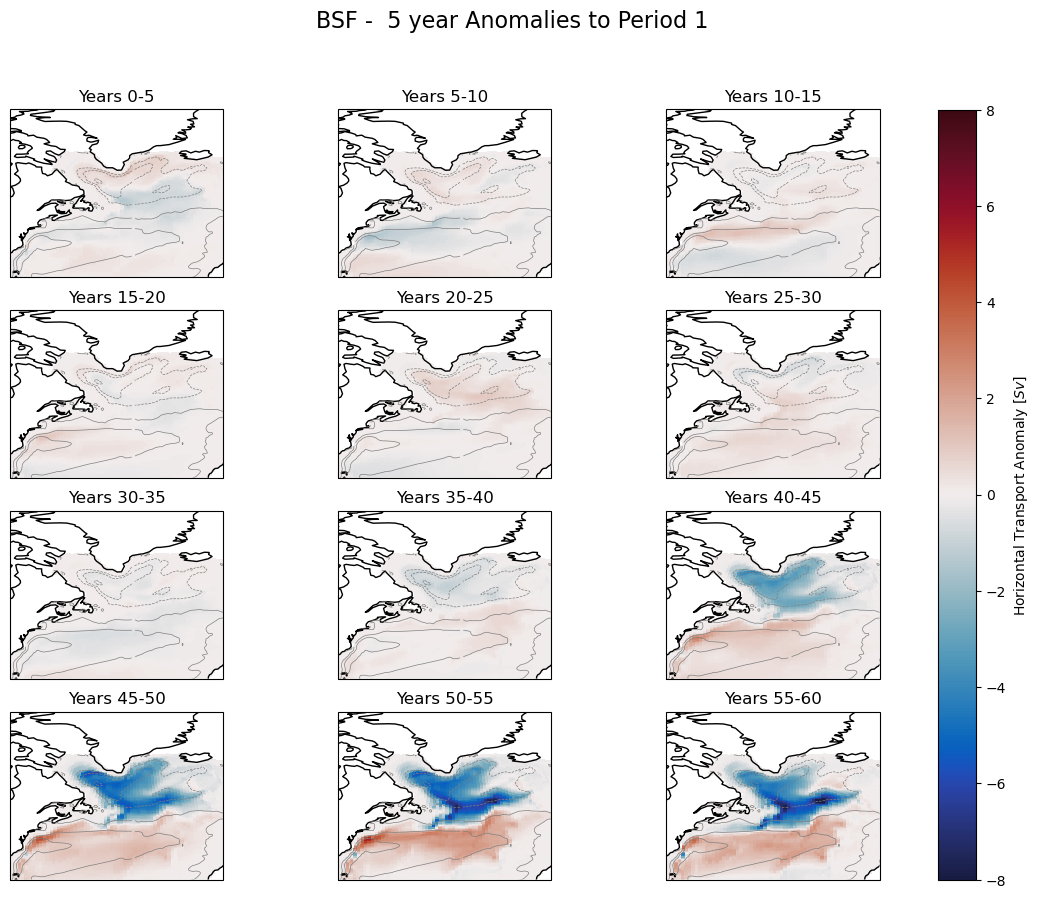

In [23]:
### INITIALISATION

files = sorted(glob.glob('/Data/gfi/share/ModData/CESM2_LENS2/ocean/monthly/comp/composite*.nc'))

print('initialisation complete')

### COMPUTATION

## create data

var = 'BSF'

print('starting with '+var)

ds_var_annual = bsf_ds

print(var+' has been loaded')

ds = ds_var_annual - ds_var_annual.isel(time=slice(0,40)).mean('time')

fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(15, 10), subplot_kw={'projection': ccrs.PlateCarree()})

# Loop through the subplots and plot the data
for i, ax in enumerate(axes.flatten()):
    
    pc = ax.pcolormesh(ds_temp.ULONG, ds_temp.ULAT, ds.isel(time=range(i * 5, i * 5 + 5)).mean('time'), 
                   transform=ccrs.PlateCarree(),
                   cmap=cmo.balance, vmin=vmin, vmax=vmax)
    
    ax.set_extent([-80,-10, 25, 80], crs=ccrs.PlateCarree())
    ax.set_title(f"Years {(i*5)}-{(i*5)+5}")
    ax.coastlines()
    
    ax.contour(ds_temp.ULONG, ds_temp.ULAT, ds_var_annual.isel(time=slice(0, 40)).mean('time'), linewidths=0.5, colors='gray',transform=ccrs.PlateCarree())

# Add a single colorbar for all plots outside the loop
cbar = fig.colorbar(pc, ax=axes, orientation='vertical', label=r'Horizontal Transport Anomaly [$Sv$]')

fig.suptitle(var+' -  5 year Anomalies to Period 1', fontsize=16)

plt.savefig(os.path.expanduser('~/phase1_CONDA/results/')+var+'_5year_anomalies.png', bbox_inches='tight', dpi=300)    
print(var+' figure has been created')

make same with dMOC

In [15]:
dmoc_file = os.path.expanduser('~/phase1_CONDA/')+'/results/composites/dMOC_anomaly.nc'
anom_dmoc_ds = xr.open_dataarray(dmoc_file)

dmoc_ds = xr.open_dataarray('/Data/gfi/share/ModData/CESM2_LENS2/ocean/monthly/comp/dMOCcomposite-test.nc')

ps_file = '/Data/gfi/share/ModData/CESM2_LENS2/ocean/monthly/temp/temp_1231.001.nc'

ds_ps = xr.open_dataset(ps_file).isel(time=0, nlon=0).squeeze()
replacement_value = 0

ds_ps['ULAT'] = xr.where(
    np.logical_or(np.isnan(ds_ps['ULAT']), np.isinf(ds_ps['ULAT']) | np.ma.getmask(ds_ps['ULAT'])),
    replacement_value,
    ds_ps['ULAT'])

ds_ps['z_t'] = ds_ps.z_t *1e-2

In [16]:
vmin = -3
vmax = -vmin

initialisation complete
starting with dMOC
dMOC has been loaded
dMOC figure has been created


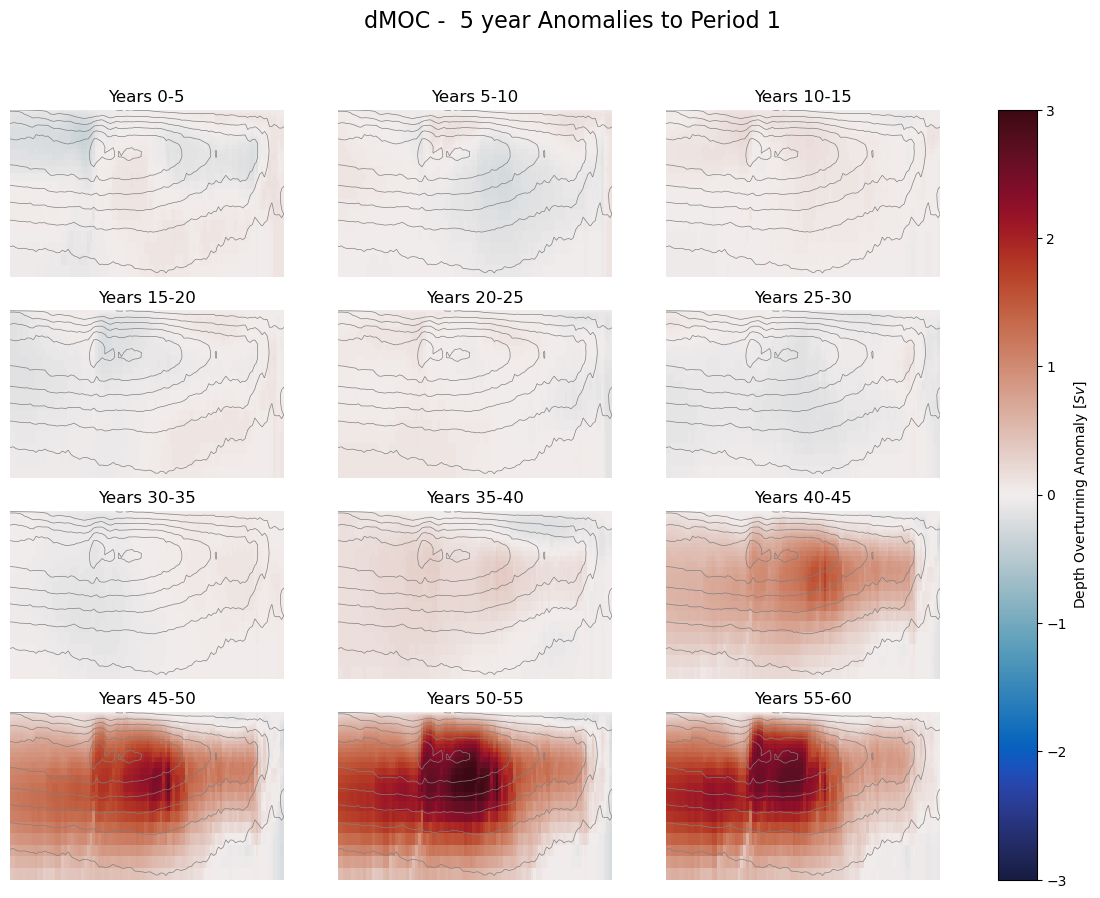

In [18]:
### INITIALISATION

files = sorted(glob.glob('/Data/gfi/share/ModData/CESM2_LENS2/ocean/monthly/comp/composite*.nc'))

print('initialisation complete')

### COMPUTATION

## create data

var = 'dMOC'

print('starting with '+var)

ds_var_annual = dmoc_ds

print(var+' has been loaded')

ds = ds_var_annual - ds_var_annual.isel(time=slice(0,40)).mean('time')

fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(15, 10))

# Loop through the subplots and plot the data
for i, ax in enumerate(axes.flatten()):
    
    pc = ax.pcolormesh(ds_ps.ULAT, ds_ps.z_t, ds.isel(time=range(i * 5, i * 5 + 5)).mean('time'), 
                   cmap=cmo.balance, vmin=vmin, vmax=vmax)
    
    ax.contour(ds_ps.ULAT, ds_ps.z_t, ds_var_annual.isel(time=slice(0, 40)).mean('time'), linewidths=0.5, colors='gray')

    ax.set_title(f"Years {(i*5)}-{(i*5)+5}")
    ax.axis('off')
    ax.invert_yaxis()
    ax.set_xlim([21, 64]) 
    ax.set_ylim([3500, 0]) 

# Add a single colorbar for all plots outside the loop
cbar = fig.colorbar(pc, ax=axes, orientation='vertical', label=r'Depth Overturning Anomaly [$Sv$]')

fig.suptitle(var+' -  5 year Anomalies to Period 1', fontsize=16)

plt.savefig(os.path.expanduser('~/phase1_CONDA/results/')+var+'_5year_anomalies.png', bbox_inches='tight', dpi=300)    
print(var+' figure has been created')

do the same with sMOC

In [2]:
smoc_ds = xr.open_dataset('/Data/gfi/share/ModData/CESM2_LENS2/ocean/monthly/comp/sMOCcomposite-test.nc')

temp_file = '/Data/gfi/share/ModData/CESM2_LENS2/ocean/monthly/temp/temp_1231.001.nc'
ds_ps = xr.open_dataset(temp_file).isel(time=0, nlon=0).squeeze()

replacement_value = 0


# Replace non-finite values and masked values
ds_ps['ULAT'] = xr.where(
    np.logical_or(np.isnan(ds_ps['ULAT']), np.isinf(ds_ps['ULAT']) | np.ma.getmask(ds_ps['ULAT'])),
    replacement_value,
    ds_ps['ULAT']
)

sigma_level =[12., 16., 20., 24., 28., 28.5, 29.2, 29.4, 29.6, 29.8, 30., 30.2, 30.4, 30.6, 30.8, 31., 31.2, 31.4, 31.6, 31.8, 32., 32.2, 32.4, 32.6, 32.8, 33., 33.2, 33.4,
                   33.6, 33.8, 34., 34.2, 34.4, 34.6, 34.8, 35., 35.1, 35.2, 35.3, 35.4, 35.5, 35.6, 35.7, 35.8, 35.9, 36, 36.1, 36.15, 36.2, 36.25, 36.3, 36.35, 
                   36.4, 36.42, 36.44, 36.46, 36.48, 36.5, 36.52, 36.54, 36.56, 36.57, 
                   36.58, 36.59, 36.6, 36.61, 36.62, 36.63, 36.64, 36.65, 36.66, 36.67, 36.68, 36.69, 36.7, 36.71, 36.72, 36.73, 36.74, 36.75, 36.76, 
                   36.78, 36.8, 36.82, 36.84, 36.86, 36.88, 36.9, 36.92, 36.94, 36.96, 36.98, 37., 37.02, 37.04, 37.06, 37.08, 37.1, 37.12, 
                   37.14, 37.16, 37.18, 37.2, 37.25, 37.3, 37.35, 37.4, 37.45, 37.6, 37.7, 37.8, 37.9, 38., 39., 40., 41., 42.]
fake_sigma = np.arange(len(sigma_level))

In [3]:
vmin = -12.5
vmax = -vmin

initialisation complete
starting with sMOC
sMOC has been loaded
sMOC figure has been created


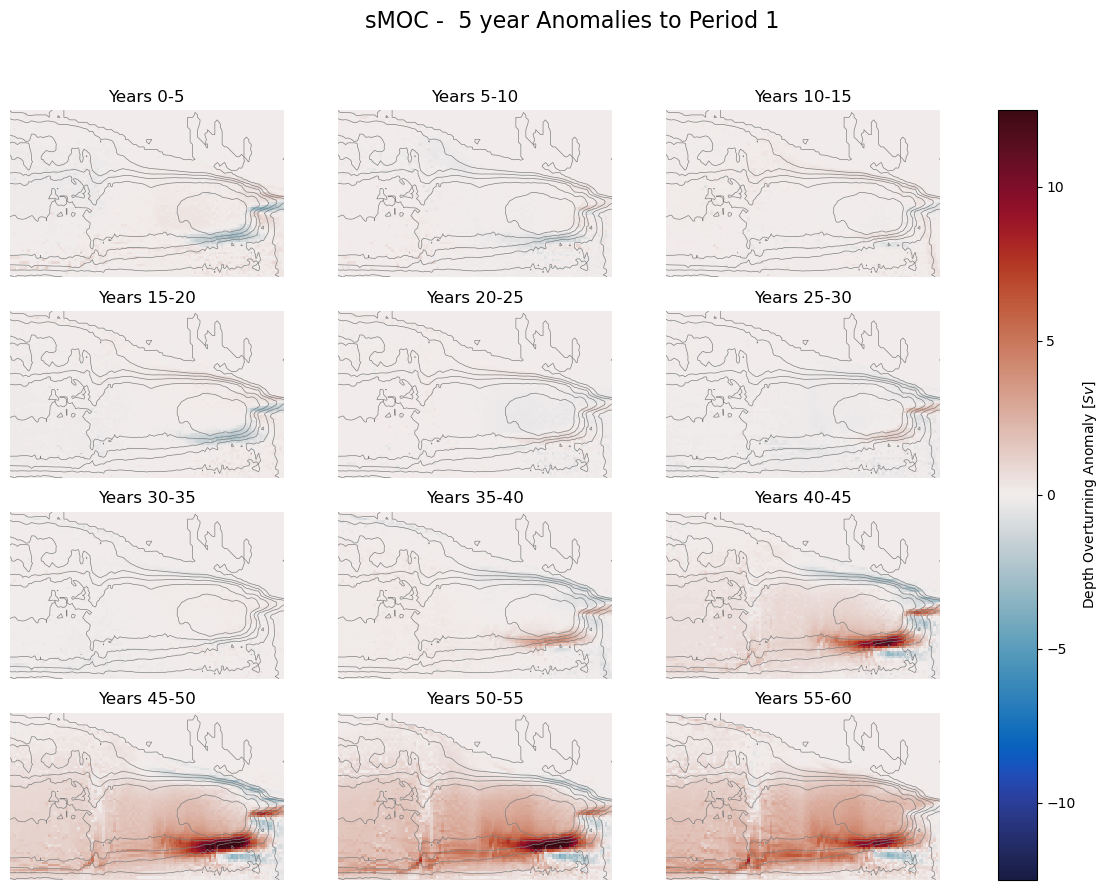

In [13]:
### INITIALISATION

files = sorted(glob.glob('/Data/gfi/share/ModData/CESM2_LENS2/ocean/monthly/comp/composite*.nc'))

print('initialisation complete')

### COMPUTATION

## create data

var = 'sMOC'

print('starting with '+var)

ds_var_annual = smoc_ds

print(var+' has been loaded')

ds = ds_var_annual - ds_var_annual.isel(time=slice(0,40)).mean('time')

fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(15, 10))

# Loop through the subplots and plot the data
for i, ax in enumerate(axes.flatten()):
    
    pc = ax.pcolormesh(ds_ps.TLAT.isel(nlat=(slice(250,365))), fake_sigma, ds.densMOC.isel(time=range(i * 5, i * 5 + 5)).mean('time'), 
                   cmap=cmo.balance, vmin=vmin, vmax=vmax)
    ax.set_title(f"Years {(i*5)}-{(i*5)+5}")
    
    ax.contour(ds_ps.TLAT.isel(nlat=(slice(250,365))), fake_sigma, ds_var_annual.densMOC.isel(time=slice(0, 40)).mean('time'), linewidths=0.5, colors='gray')

    ax.set_xlim([21, 64])  
    ax.set_ylim([15, 83])
    ax.invert_yaxis()
    ax.axis('off')

# Add a single colorbar for all plots outside the loop
cbar = fig.colorbar(pc, ax=axes, orientation='vertical', label=r'Depth Overturning Anomaly [$Sv$]')

fig.suptitle(var+' -  5 year Anomalies to Period 1', fontsize=16)

plt.savefig(os.path.expanduser('~/phase1_CONDA/results/')+var+'_5year_anomalies.png', bbox_inches='tight', dpi=300)    
print(var+' figure has been created')

In [ ]:
pc = ax.pcolormesh(ds_ps.TLAT.isel(nlat=(slice(250,365))), fake_sigma, anom_smoc_ds.densMOC,
                   cmap=cmo.balance,
                   vmin=vmin, vmax=vmax)